In [3]:
# Python
import os
import numpy as np
from dataclasses import dataclass

# Pytorch
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Lambda, ToPILImage
import lightning as L

# HuggingFace
import datasets
import diffusers

# Visualization
from tqdm.auto import tqdm
import PIL

In [10]:
class LightningDiffusion(L.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.config = config

        # define up and down blocks for unet,
        # e.g. block_out_channels = (64, 128, 256, 256) and num_attn_blocks = 1
        # -> ['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D']
        # -> ['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D']
        down_blocks = [
            "AttnDownBlock2D" if blk < config.num_attn_blocks else "DownBlock2D"
            for blk in reversed(range(len(config.block_out_channels)))
        ]

        up_blocks = [
            "AttnUpBlock2D" if blk < config.num_attn_blocks else "UpBlock2D"
            for blk in range(len(config.block_out_channels))
        ]

        # define unet (2D = images)
        self.unet = diffusers.UNet2DModel(
            sample_size=config.image_size,
            in_channels=config.image_channels,
            out_channels=config.image_channels,
            layers_per_block=config.layers_per_block,
            block_out_channels=config.block_out_channels,
            down_block_types=down_blocks,
            up_block_types=up_blocks,
        )

        # define noise scheduler
        self.noise_scheduler = diffusers.DDPMScheduler(
            num_train_timesteps=config.num_train_timesteps
        )

    def configure_optimizers(self):
        # use Adam optimizer
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.config.learning_rate
        )

        # define learning rate scheduler: linear warmup with cosine decay
        scheduler = diffusers.optimization.get_scheduler(
            name="cosine",
            optimizer=optimizer,
            num_warmup_steps=self.config.lr_warmup_steps,
            num_training_steps=self.config.num_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # update lr-rate after every step instead of every epoch
            },
        }

    def forward(self, noisy_images, timesteps):
        return self.unet(noisy_images, timesteps)["sample"]

    def training_step(self, batch, batch_idx):
        clean_images = batch["images"]
        batch_size = len(clean_images)
        device = clean_images.device

        # sample random noise
        noise = torch.randn(clean_images.shape).to(device)

        # get random timesteps
        timesteps = torch.randint(
            0, self.noise_scheduler.config.num_train_timesteps, (batch_size,)
        ).to(device)

        # add noise to images, depending on timestep
        noisy_images = self.noise_scheduler.add_noise(
            clean_images, noise, timesteps
        )

        # predict noise at given timesteps
        noise_pred = self(noisy_images, timesteps)

        # evaluate loss function (TODO: compare soft-L1 vs L2)
        loss = F.mse_loss(noise_pred, noise)
        self.log("Loss", loss.item(), prog_bar=True)

        # log learning rate
        lr = trainer.lr_scheduler_configs[0].scheduler.get_last_lr()[0]
        self.log("lr", lr, prog_bar=True)

        return loss

    def sample(self, n_samples=1, num_timesteps=50, seed=42, pbar=True):
        # create sampling pipeline
        pipeline = diffusers.DDPMPipeline(
            unet=self.unet, scheduler=self.noise_scheduler
        )
        pipeline.set_progress_bar_config(disable=not pbar)

        # sample images
        if num_timesteps is None:
            num_timesteps = self.config.num_sample_timesteps

        return pipeline(
            batch_size=n_samples,
            num_inference_steps=num_timesteps,
            generator=torch.Generator(device="cpu").manual_seed(seed),
        )["images"]

    def on_train_epoch_end(self):
        # sample some images
        images = model.sample(
            n_samples=16, num_timesteps=50, seed=0, pbar=False
        )

        # concat outputs and save as one jpg
        save_path = f"lightning_logs/version_{self.logger.version}/intermediate_results/"
        os.makedirs(save_path, exist_ok=True)

        image_grid = diffusers.utils.make_image_grid(images, rows=4, cols=4)
        image_grid.resize((512, 512)).save(
            save_path + f"out_step-{self.global_step}.jpg"
        )

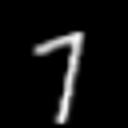

In [11]:
# prepare dataset
def transform(dataset):
    preprocess = Compose(
        [
            Resize((32, 32)),
            ToTensor(),
            Lambda(lambda x: 2 * (x - 0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}


dataset = datasets.load_dataset("mnist", split="train")
dataset.set_transform(transform)

sample_image = dataset[42]["images"]
ToPILImage()(sample_image / 2 + 0.5).resize((128, 128))

In [12]:
@dataclass
class ModelConfig:
    image_size = dataset[0]["images"].shape[1]
    image_channels = dataset[0]["images"].shape[0]
    block_out_channels = (64, 128, 256, 256)
    num_attn_blocks = 3
    layers_per_block = 2
    num_train_timesteps = 1000
    num_sample_timesteps = 50
    train_batch_size = 32
    eval_batch_size = 16
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    num_training_steps = (
        min(lr_warmup_steps, len(dataset) // train_batch_size) * num_epochs
    )
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "bf16"
    seed = 0


config = ModelConfig()

In [13]:
# create model
model = LightningDiffusion(config)

# train model
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True
)

trainer = L.Trainer(
    max_epochs=config.num_epochs,
    precision=config.mixed_precision,
    limit_train_batches=config.lr_warmup_steps,
    gradient_clip_val=1.0,
    fast_dev_run=False,
)
trainer.fit(model, train_dataloader)

c:\Users\Gregor\miniforge3\envs\diffusion\lib\site-packages\lightning\fabric\connector.py:572: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params | Mode 
---------------------------------------------
0 | unet | UNet2DModel | 27.0 M | train
---------------------------------------------
27.0 M    Trainable params
0         Non-trainable params
27.0 M    Total params
107.810   Total estimated model params size (MB)
351       Modules in train mode
0         Modules in eval mode
c:\Users\Gregor\miniforge3\envs\diffusion\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consi

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/1000 [00:00<?, ?it/s]

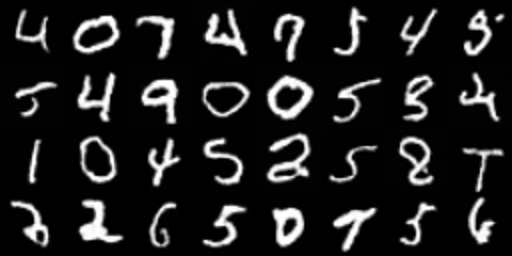

In [14]:
model.cuda()  # move to cuda
images = model.sample(
    n_samples=32, num_timesteps=1000, seed=np.random.randint(1e8)
)

diffusers.utils.make_image_grid(images, rows=4, cols=8).resize((512, 256))